# Do Male and Female Athletes Get Olympic Medals at Different Age

The dataset used here is this: https://data.world/msantolini/individual-performance-in-team/workspace/file?filename=Olympics.tsv . I took a subset of this dataset using this SQL command:
```sql
SELECT * FROM olympics WHERE trigram="USA"
```
The every individual who participated in *Summer* olympics for USA. I will use the dataset to find the answer to the question: **Do Male and Female Athletes Get Olympic Medals at Different Age?**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from scipy import stats
%matplotlib notebook

## Loading the dataset and gathering important data

In [2]:
df = pd.read_csv("individual-performance-in-team-QueryResult.csv")
df

,trigram,country,year,event,rank,athlete,gender,age,sport,gold,silver,bronze,total,athlete_unique_url
0,USA,United States,2014,Winter,1,"Davis,Meryl",Female,27.0,Figure Skating,1,0,1,2,/olympics/athletes/da/meryl-davis-1.html
1,USA,United States,2014,Winter,2,"White,Charlie",Male,26.0,Figure Skating,1,0,1,2,/olympics/athletes/wh/charlie-white-1.html
2,USA,United States,2014,Winter,3,"Holcomb,Steve",Male,33.0,Bobsleigh,0,0,2,2,/olympics/athletes/ho/steve-holcomb-1.html
3,USA,United States,2014,Winter,4,"Langton,Steve",Male,30.0,Bobsleigh,0,0,2,2,/olympics/athletes/la/steve-langton-1.html
4,USA,United States,2014,Winter,5,"Anderson,Jamie",Female,23.0,Snowboarding,1,0,0,1,/olympics/athletes/an/jamie-anderson-1.html
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12293,USA,United States,1896,Summer,10,"Jamison,Herbert",Male,20.0,Athletics,0,1,0,1,/olympics/athletes/ja/herbert-jamison-1.html
12294,USA,United States,1896,Summer,11,"Tyler,Albert",Male,24.0,Athletics,0,1,0,1,/olympics/athletes/ty/albert-tyler-1.html
12295,USA,United States,1896,Summer,12,"Lane,Frank",Male,21.0,Athletics,0,0,1,1,/olympics/athletes/la/frank-lane-1.html
12296,USA,United States,1896,Summer,13,"Waldstein,Charles",Male,40.0,Shooting,0,0,0,0,/olympics/athletes/wa/charles-waldstein-1.html


### We will focus only on summer olympics. As our question involves *medals* , we will take only those participants who has won at least one medal. We will not distinguish between gold, silver and bronze.

In [3]:
df = df[(df["event"]=="Summer") & (df["total"] > 0)][["year","event","gender","age","total"]].reset_index(drop=True)
df.head()

,year,event,gender,age,total
0,2012,Summer,Male,27.0,6
1,2012,Summer,Female,17.0,5
2,2012,Summer,Female,22.0,5
3,2012,Summer,Male,27.0,5
4,2012,Summer,Female,26.0,3


## Grouping the datasets
### We will split male and female in two datasets to compare them.

In [4]:
male = df[df["gender"]=="Male"]
male.head(2)

,year,event,gender,age,total
0,2012,Summer,Male,27.0,6
3,2012,Summer,Male,27.0,5


In [5]:
female = df[df["gender"]=="Female"]
female.head(2)

,year,event,gender,age,total
1,2012,Summer,Female,17.0,5
2,2012,Summer,Female,22.0,5


In [6]:
len(male) + len(female) == len(df) ## Checking if there is a third gender

True

### Group male and females by **age** to get only number of medals per age group

In [7]:
male_total = male.groupby("age")["total"].count()
print(len(male_total))
print(male_total.index.max(),male_total.index.min())
female_total = female.groupby("age")["total"].count()
print(len(female_total))
print(female_total.index.max(),female_total.index.min())

47
68.0 14.0
37
63.0 12.0


### Fill missing age groups and do sorting

In [8]:
for i in range(int(min(male_total.index.min(),female_total.index.min())),
               int(max(male_total.index.max(),female_total.index.max()))+1):
    if i not in  male_total.index:
        male_total = male_total.append(pd.Series({i:0}))
    if i not in  female_total.index:
        female_total = female_total.append(pd.Series({i:0}))
print(len(male_total))
print(male_total.index.max(),male_total.index.min())
print(len(female_total))
print(female_total.index.max(),female_total.index.min())

57
68.0 12.0
57
68.0 12.0


In [9]:
male_total.sort_index(inplace=True)
female_total.sort_index(inplace=True)
print(male_total.tail(3))
print(male_total.tail(3))

66.0    0
67.0    0
68.0    2
dtype: int64
66.0    0
67.0    0
68.0    2
dtype: int64


## Making another dataset that can be used to apply Test
### This dataset is same as previous age groups, but it containg only how many times any age group appeared. It can be used in statistical tests such as: t-test.

In [10]:
m = male.groupby("age").count()["total"]
mdata = []
for i in m.index:
    mdata.extend([i]*m[i])
mdata = np.array(mdata)
f = female.groupby("age").count()["total"]
fdata = []
for i in f.index:
    fdata.extend([i]*f[i])
fdata = np.array(fdata)
print(mdata.mean(),fdata.mean())

25.398959881129272 24.1070796460177


## Plotting Tthe data
### We will plot the data now. 
### First bar chart represents Male madels vs age group
### Second bar chart represents Female madels vs age group
### Third plot conntains Confidence interval and result of t-test

<IPython.core.display.Javascript object>


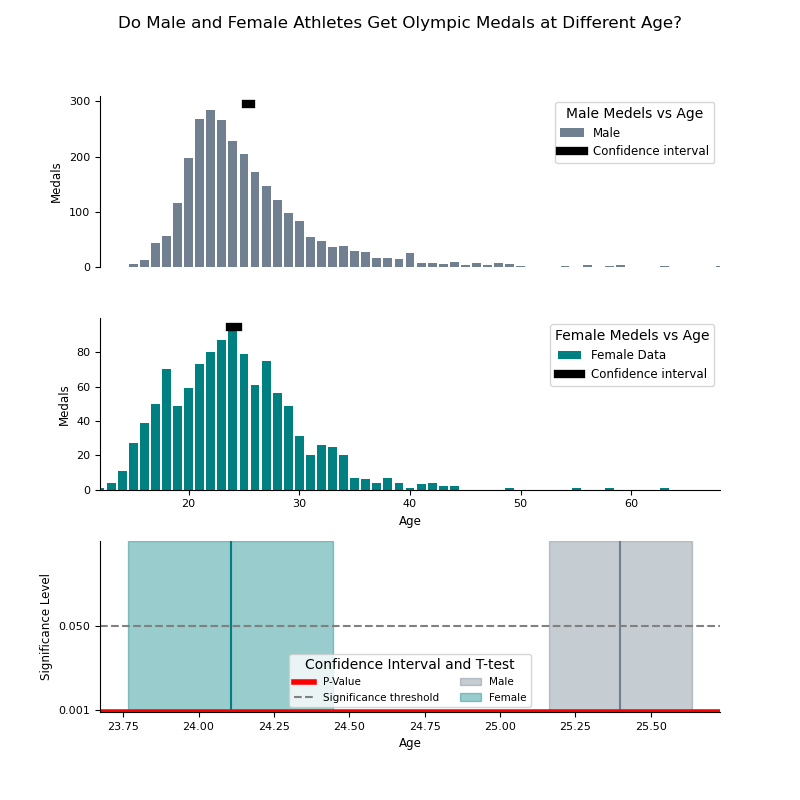

In [11]:
plt.figure(figsize=(8,8))
plt.subplot("311")
plt.suptitle("Do Male and Female Athletes Get Olympic Medals at Different Age?")
plt.bar(male_total.index,male_total, color="slategray", label="Male")
l, h = sms.DescrStatsW(mdata).tconfint_mean()
plt.errorbar([l,h],[295,295], linewidth=6, color="black", label="Confidence interval", zorder=2)
plt.xlim([12,68])
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.yticks(fontsize=8)
plt.tick_params(bottom=False, labelbottom=False)
plt.legend(title="Male Medels vs Age", fontsize=8.5)
plt.ylabel("Medals", fontsize=8.5)

plt.subplot("312")
plt.bar(female_total.index,female_total, color="teal", label="Female Data")
l, h = sms.DescrStatsW(fdata).tconfint_mean()
plt.errorbar([l,h],[95,95], linewidth=6, color="black", label="Confidence interval", zorder=2)
plt.xlim([12,68])
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title="Female Medels vs Age",fontsize=8.5)
plt.ylabel("Medals", fontsize=8.5)
plt.xlabel("Age", fontsize=8.5)

plt.subplot("313")
l, h = sms.DescrStatsW(mdata).tconfint_mean()
plt.axvspan(l,h,color="slategray", alpha=0.4, label="Male")
plt.axvline(mdata.mean(), color="slategray")
l, h = sms.DescrStatsW(fdata).tconfint_mean()
plt.axvspan(l,h,color="teal", alpha=0.4, label="Female")
plt.axvline(fdata.mean(), color="teal")
t_value, p_value = stats.ttest_ind(mdata,fdata)

plt.axhline(p_value, color="red", label="P-Value", linewidth=4)
plt.axhline(0.05, color="gray", linestyle="dashed", label="Significance threshold")
plt.legend(title="Confidence Interval and T-test", fontsize=7.5, ncol=2)
plt.ylim([0,0.1])
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.xticks(fontsize=8)
plt.yticks([0.001, 0.05], fontsize=8)
plt.xlabel("Age", fontsize=8.5)
plt.ylabel("Significance Level", fontsize=8.5)
plt.subplots_adjust(hspace=0.3)

### The result of t-test

In [12]:
print("T-Value of T-test is:", t_value)

T-Value of T-test is: 5.934253179914275


In [13]:
print("P-Value of T-test is:", p_value)

P-Value of T-test is: 3.214381551589107e-09


In [14]:
plt.savefig("plot.jpg", dpi=300, format="jpg")

## Decision

Our null hypothesis is:  Male and Female Athletes Get Olympic Medals at **same** Age.  
and alternate hypothesis is: Male and Female Athletes Get Olympic Medals at **different** Age

Firstly we plotted male and female madels vs age group. That gave us similar kind of bars, but it looks like female starts getting medals at lower ages than male. To proove whether this visual difference is significant or not, we first plot confidence intervals. If the confidence intervals do not overlap, we may proove that our null hypothesis can be rejected.

The confidence intervals does not overlap. So, null hypothesis can be rejected. We will perform an additional t-test. 

Greater value of **t_value** represents that male and females age range are *more* different. We will use the **p_value** to reach our decision. If the p_value is less than 0.05, we will take male and female age range are different and null hypothesis can be rejected.

By performing t-test, we get: P-Value of T-test is: 3.214381551589107e-09
and T-Value is: 5.934253179914275  


As P-value is < 0.05, null hypothesis can be rejected.

### So, Male and Female Athletes Get Olympic Medals at different Age.

Most of the females get olympic medal between the age of 23.76 and 24.44 on average.  
But most of the males get olympic medal between the age of 25.16 and 25.63 on average. 